In [21]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [36]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


In [47]:
example = mini_train_data[:1]


In [146]:
# Credit where due... some inspiration drawn from:
# https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/fig/mnist.py

# example_as_pixel_matrix():
#   transforms a 784 element pixel into a 28 x 28 pixel matrix
def example_as_pixel_matrix(example):
    return np.reshape(example, (-1, 28))

# add_example_to_figure():
#   given an existing figure, number of rows, columns, and position,
#   adds a subplot with the example to the figure
def add_example_to_figure(example, 
                     figure, 
                     subplot_rows, 
                     subplot_cols, 
                     subplot_number):
    matrix = example_as_pixel_matrix(example)

    subplot = figure.add_subplot(subplot_rows, subplot_cols, subplot_number)
    subplot.imshow(matrix, cmap='Greys', interpolation='Nearest')
    # disable tick marks
    subplot.set_xticks(np.array([]))
    subplot.set_yticks(np.array([]))

# plot_examples():
#   given a matrix of examples (digit, example#) => example, 
#   plots it with digits as rows and examples as columns
def plot_examples(examples):
    
    figure = plt.figure()
    
    shape = np.shape(examples)
    rows = shape[0]
    columns = shape[1]
    
    subplot_index = 1
    
    for digit, examples_for_digit in enumerate(examples):
        for example_index, example in enumerate(examples_for_digit):
            add_example_to_figure(example, 
                                  figure, 
                                  rows, 
                                  columns, 
                                  subplot_index
                                 )
            subplot_index = subplot_index + 1
    
    figure.tight_layout()
    plt.show()

# plot_one_example():
#   given an example, plots only that example, typically
#   for debugging or diagnostics
def plot_one_example(example):  
    examples = [ [ example ] ]
    plot_examples(examples)

# select_indices_of_digit():
#   given an array of digit lables, selects the indices of
#   labels that match a desired digit
def select_indices_of_digit(labels, digit):
    return [i for i, label in enumerate(labels) if label == digit]

# take_n_from():
#   code readability sugar for taking a number of elements from an array
def take_n_from(count, array):
    return array[:count]

# take_n_examples_by_digit():
#   given a data set of examples, a label set, and a parameter n,
#   creates a matrix where the rows are the digits 0-9, and the
#   columns are the first n examples of each digit
def take_n_examples_by_digit(data, labels, n):
    examples = [
        data[take_n_from(n, select_indices_of_digit(labels, digit))]
        for digit in range(10)
    ]
    return examples

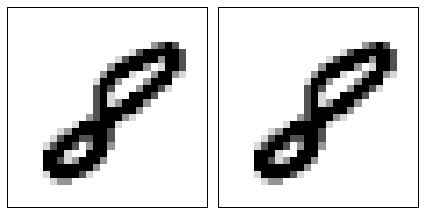

In [129]:
examples = [ [ example, example ] ]
plot_examples(examples)

In [135]:
indices_8 = [i for i, digit in enumerate(mini_train_labels) if digit == 8]
mini_train_labels[indices_8]


array([ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.])

In [143]:
take(select_indices_of_digit(mini_train_labels, 8), 10)

[0, 21, 49, 52, 62, 74, 105, 113, 116, 159]

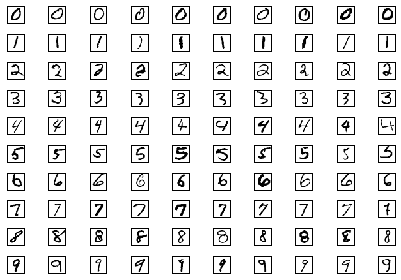

In [150]:
examples = take_n_examples_by_digit(mini_train_data, mini_train_labels, 10)
plot_examples(examples)